Epoch 0: Loss = 2.430044e+01
Epoch 500: Loss = 8.179913e-01
Epoch 1000: Loss = 4.482635e-02
Epoch 1500: Loss = 1.747489e-03
Epoch 2000: Loss = 9.669341e-04
Epoch 2500: Loss = 5.968498e-04
Epoch 3000: Loss = 4.270888e-04
Epoch 3500: Loss = 2.774598e-04
Epoch 4000: Loss = 1.935068e-04
Epoch 4500: Loss = 1.432856e-04


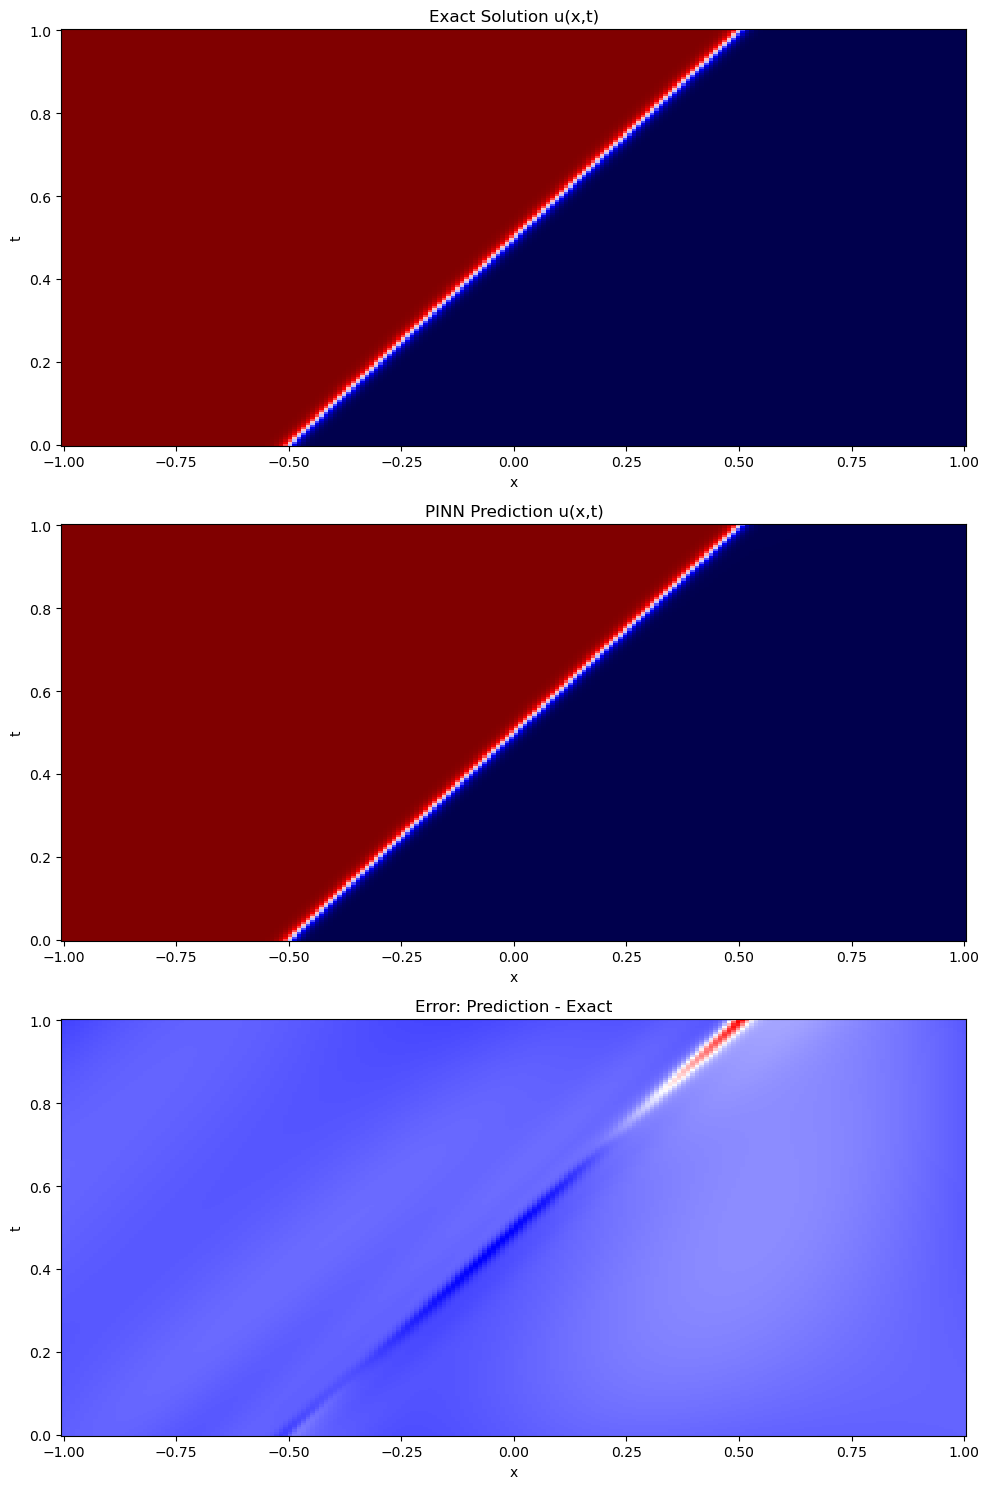

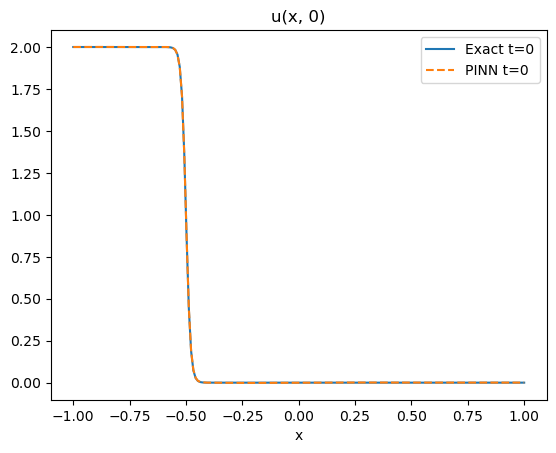

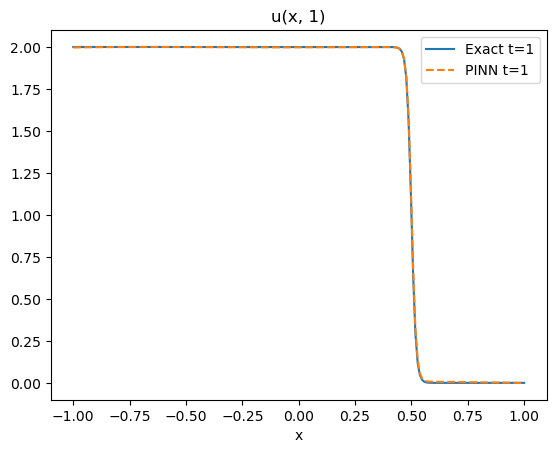

In [ ]:
# PINN for Burgers' equation using exact BCs and ICs from the analytical solution

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Precision and device
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the exact solution
def u_exact_fn(x, t, eps):
    return -torch.tanh((x + 0.5 - t) / (2 * eps)) + 1

# PINN model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

# Gradient helper
def grad(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

# PDE loss function
def loss_fn(model, x, t, eps):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = grad(u, t)
    u_x = grad(u, x)
    u_xx = grad(u_x, x)
    f = u_t + 0.5 * grad(u**2, x) - eps * u_xx

    u_exact = u_exact_fn(x, t, eps)
    u0_exact = u_exact_fn(x, torch.zeros_like(t), eps)

    x_bc = torch.tensor([[-1.0], [1.0]], device=device).repeat(t.shape[0] // 2, 1)
    t_bc = t[:x_bc.shape[0]]
    u_bc_pred = model(x_bc, t_bc)
    u_bc_true = u_exact_fn(x_bc, t_bc, eps)

    u_ic_pred = model(x, torch.zeros_like(t))
    loss_pde = torch.mean(f**2)
    loss_ic = torch.mean((u_ic_pred - u0_exact)**2)
    loss_bc = torch.mean((u_bc_pred - u_bc_true)**2)

    return loss_pde + 10 * loss_ic + 10 * loss_bc

# Domain setup
eps = 0.01
nx, nt = 200, 200
x = torch.linspace(-1, 1, nx, device=device).unsqueeze(1)
t = torch.linspace(0, 1, nt, device=device).unsqueeze(1)
x_mesh, t_mesh = torch.meshgrid(x.flatten(), t.flatten(), indexing='ij')
x_mesh = x_mesh.reshape(-1, 1)
t_mesh = t_mesh.reshape(-1, 1)

# Initialize model
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_fn(model, x_mesh, t_mesh, eps)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6e}")

# Predictions for plotting
model.eval()
x_eval, t_eval = x_mesh.detach(), t_mesh.detach()
u_pred = model(x_eval, t_eval).cpu().detach().numpy()
u_true = u_exact_fn(x_eval, t_eval, eps).cpu().numpy()
error = u_pred - u_true

# Reshape for plotting
u_pred = u_pred.reshape(nx, nt)
u_true = u_true.reshape(nx, nt)
error = error.reshape(nx, nt)


In [ ]:

# Plot 2D results
x_cpu = x.cpu().numpy()
t_cpu = t.cpu().numpy()
x_edges = np.append(x_cpu, x_cpu[-1] + (x_cpu[1] - x_cpu[0])) - (x_cpu[1] - x_cpu[0]) / 2
t_edges = np.append(t_cpu, t_cpu[-1] + (t_cpu[1] - t_cpu[0])) - (t_cpu[1] - t_cpu[0]) / 2

fig1, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].pcolormesh(x_edges, t_edges, u_true.T, shading='auto', cmap='seismic')
axs[0].set_title("Exact Solution u(x,t)")
axs[1].pcolormesh(x_edges, t_edges, u_pred.T, shading='auto', cmap='seismic')
axs[1].set_title("PINN Prediction u(x,t)")
axs[2].pcolormesh(x_edges, t_edges, error.T, shading='auto', cmap='bwr')
axs[2].set_title("Error: Prediction - Exact")
for ax in axs:
    ax.set_xlabel("x")
    ax.set_ylabel("t")
plt.tight_layout()
plt.show()

# Plot u(x,0) and u(x,1)
t0 = torch.zeros_like(x)
t1 = torch.ones_like(x)
u0_pred = model(x, t0).cpu().detach().numpy()
u0_true = u_exact_fn(x, t0, eps).cpu().numpy()
u1_pred = model(x, t1).cpu().detach().numpy()
u1_true = u_exact_fn(x, t1, eps).cpu().numpy()

fig2, ax2 = plt.subplots()
ax2.plot(x_cpu, u0_true, label='Exact t=0')
ax2.plot(x_cpu, u0_pred, '--', label='PINN t=0')
ax2.set_title("u(x, 0)")
ax2.set_xlabel("x")
ax2.legend()
plt.show()

fig3, ax3 = plt.subplots()
ax3.plot(x_cpu, u1_true, label='Exact t=1')
ax3.plot(x_cpu, u1_pred, '--', label='PINN t=1')
ax3.set_title("u(x, 1)")
ax3.set_xlabel("x")
ax3.legend()
plt.show()
